# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [ ]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [ ]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [ ]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [ ]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [ ]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [ ]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [ ]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 
def f4(x, y):
    x = np.array(x)
    y = np.array(y)
    return  x**2 + y**2

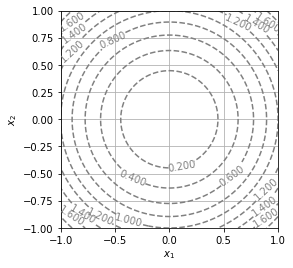

In [ ]:
display_contour(
    f4, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

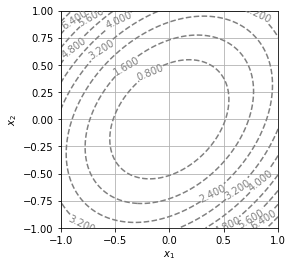

In [ ]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 1000), 
    y=np.linspace(-1.0, 1.0, 1000), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [ ]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

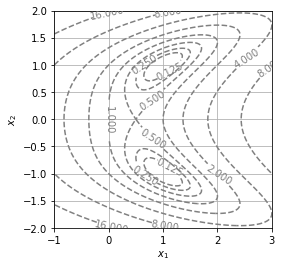

In [ ]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 1000), 
    y=np.linspace(-2.0, 2.0, 1000), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [ ]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

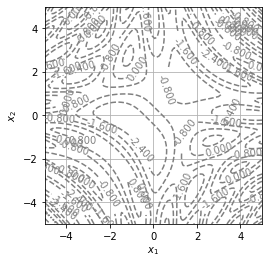

In [ ]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [ ]:
N = 1000
eps = 0.1

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [ ]:

def Newton(F, x0, y0, eps=eps, N=N):
    J_f= J(F)
    H0= np.array([x0,y0], dtype=np.float64)
    for i in range(N):
        H0= H0- (np.linalg.inv(J_f(x0,y0)))@F(x0,y0)
        if np.sqrt((H0[0] - x0)**2 + (H0[1] - y0)**2) <= eps:
            return H0[0], H0[1]
        x0, y0 = H0[0], H0[1]
    else:
        raise ValueError(f"no convergence in {N} steps.")
        


In [ ]:
def F1(x, y):
    return np.array([f1(x,y)-0.8, x-y])
x,y = Newton(F1, 0.8, 0.8)
f1(x,y)
# le resultat est satisfaisant pour les paramètres de précision choisi
#temps d'execution instantanné pour cet exemple
# L'ordre de grandeur du eps choisi permet d'avoir un compromi entre la précision et la nécessité de faire converger le programme au bout des N coups

0.8001311455637322

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [ ]:
def level_curve(f, x0, y0, c, delta= 0.1, N=10000):
  def F(x, y):
    grad_f = grad(f)
    gradient= grad_f(x,y)
    Norme = np.sqrt((gradient[1]**2+gradient[0]**2))
    unit= np.array([gradient[1], -gradient[0]])*(delta/Norme)
    x1,y1= np.array([x0,y0])+ unit 
    return np.array([f(x,y)-c,(x-x1)**2 + (y-y1)**2])
  Points= np.array([])
  for i in range(N-1):
    x_n, y_n= Newton(F, x0, y0)
    Points= np.concatenate((Points,np.array([x_n, y_n]) ))
    (x0, y0) = (x_n, y_n)
    if len(Points)>100 and np.sqrt(((x_n-Points[0])**2 + (y_n-Points[1])**2))< delta/3:
      return np.concatenate((Points,np.array(Newton(F, x_n, y_n)) ))
  return np.concatenate((Points,np.array(Newton(F, x_n, y_n)) ))

le nombre de points necessaire au bouclage de pas delta : 478


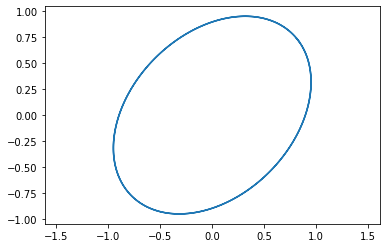

In [ ]:
def F1(x, y):
    return np.array([f1(x,y)-2.4, x-y])
x, y= Newton(F1, 0.7, 0.7)
val= level_curve(f1, x, y, 2.4 )
abscisse= [val[i] for i in range(len(val)) if i%2==0]
ordonnée= [val[i] for i in range(len(val)) if i%2!=0]
print(f"le nombre de points necessaire au bouclage de pas delta : {len(val)}")
plt.plot(abscisse, ordonnée)
plt.axis('equal');

le nombre de points necessaire au bouclage de pas delta : 3204


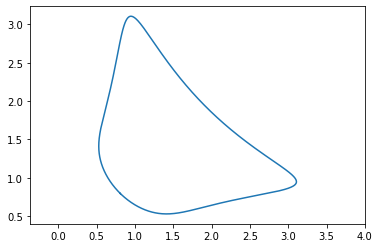

In [ ]:
def F3(x, y):
    return np.array([f3(x,y)+0.8, x-y])
x, y= Newton(F1, 0.84, 0.78)

val= level_curve(f3, x, y, -0.8, 0.01, 40000)
abscisse= [val[i] for i in range(len(val)) if i%2==0]
ordonnée= [val[i] for i in range(len(val)) if i%2!=0]
print(f"le nombre de points necessaire au bouclage de pas delta : {len(val)}")
plt.plot(abscisse, ordonnée)
plt.axis('equal');

[2.42297799 1.00631133 2.38637023 ... 1.0063664  2.38512753 0.97097258] 1682


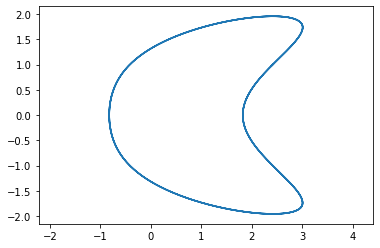

In [ ]:
val= level_curve(f2, 2.5,1., 4, 0.1, 40000)
abscisse= [val[i] for i in range(len(val)) if i%2==0]
ordonnée= [val[i] for i in range(len(val)) if i%2!=0]
print(val, len(val))
plt.plot(abscisse, ordonnée)
plt.axis('equal');

Le modèle utilisé est assez fidèle à la representation des courbes de niveau avec un temps d'execution raisonnable en fonction du pas d'avancement delta souhaitée. Cependant ce temps peut-être pus ou moins long en fonction du pas delta à cause de la condition de sortie qui est le retour à la boule de centre (x0, y0) et de rayon delta/10 (choix utilisé) après quelques iterations initiales.

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [ ]:
import copy


In [ ]:
def aire_carre(f, x0, y0, c, h):
  vale= level_curve(f, x0, y0, c)
  domaine = np.linspace(vale.min(), vale.max(), 1000)
  segment1 = list()
  intervalle = np.arange(vale.min(), vale.max(), h)
  for i in intervalle :
    segment1.append(np.linspace(i, i+h, 5))
  segment2 = copy.deepcopy(segment1)
  centre1 = [(seg[0]+seg[-1])/2 for seg in segment1] 
  centre2 = [(seg[0]+seg[-1])/2 for seg in segment2] 
  carres = []
  for i, x in enumerate(centre1):
    for j, y in enumerate(centre2):
      if f(x,y)<= c :
        carre = [segment1[i], segment2[j]]
        aire = (carre[0][-1]-carre[0][0])*(carre[1][-1]-carre[1][0])
        carres += [aire]
  
  return sum(carres) 






In [ ]:
def comportement(f, x0, y0, c, A, intervalle_h= np.linspace(0.001, 0.5, 10 )):
  absolue = []
  for h in intervalle_h :
    absolue += [aire_carre(f, x0, y0, c, h)]
  absolue_plot = np.absolute([x-A for x in absolue])
  plt.plot(np.log10(intervalle_h), np.log10(absolue_plot))
  plt.suptitle("Evolution de l'erreur absolue en log-log")
  plt.xlabel('h')
  plt.ylabel('|A_h − A|')
  plt.axis('equal')
#peu prendre beaucoup de temps en fonctions de "intervalle_h"


In [ ]:
aire_carre(f4, 1., 0., 1, 0.001 )
# 1mn
# bonne précision à 10e-3 près de pi pour h=0.001, biensur on a des limites au dela d'un certain h à cause des arrondis numérique et du temps d'execution du au découpage des carrées

3.1416040000852226

In [ ]:
aire_carre(f4, 1., 0., 1, 0.1 )
#18s 
#pour h= 0.1 bonne approximation à 10e-1 près

3.1599999999999766

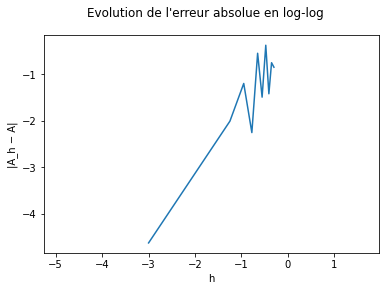

In [ ]:
comportement(f4, 1., 0., 1, np.pi)
#3mn pour 10 points de h entre 0.001 et 0.5 
#les paramètres peuvent être modifiés pour avoir un meilleure representation mais le temps sera modulé en consequence

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

2516


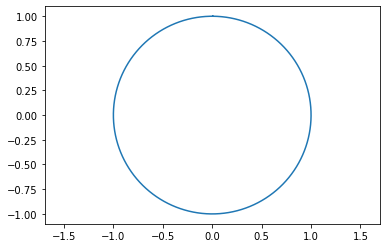

In [ ]:
val= level_curve(f4, 0., 1., 1., 0.01, 100000)
abscisse= [val[i] for i in range(len(val)) if i%2==0]
ordonnee= [val[i] for i in range(len(val)) if i%2!=0]
print(len(val))
plt.plot(abscisse, ordonnee)
plt.axis('equal');
#Illustration de la generation des points pour le cercle unité avec delta(pas d'avancement) = 0.1, 5024 points utilisés pour boucler la ligne de niveau

In [ ]:
def Aire_triangle2(f, x0, y0, c, xp, yp) :
  val= level_curve(f, x0, y0, c, 0.01, 40000)
  abscisse= np.array([val[i] for i in range(len(val)) if i%2==0])
  ordonnee= np.array([val[i] for i in range(len(val)) if i%2!=0])
  vect_z= np.array([])
  for i in range(len(abscisse)-1):
    vect_z= np.concatenate((vect_z, np.array([abscisse[i+1]-abscisse[i]]), np.array([ordonnee[i+1]-ordonnee[i]])))
    
  abscisse_z= np.array([vect_z[i] for i in range(len(vect_z)) if i%2==0])
  ordonnee_z= np.array([vect_z[i] for i in range(len(vect_z)) if i%2!=0])
  vect_p= np.array([])
  for i in range(len(abscisse)):
    vect_p= np.concatenate((vect_p, np.array([abscisse[i]- xp]), np.array([ordonnee[i]- yp])))
  abscisse_p= np.array([vect_p[i] for i in range(len(vect_p)) if i%2==0])
  ordonnee_p= np.array([vect_p[i] for i in range(len(vect_p)) if i%2!=0])

  aire = np.array([])

  for i in range(len(abscisse_z)):
    z_i= np.array([abscisse_z[i], ordonnee_z[i]])
    p_i= np.array([abscisse_p[i], ordonnee_p[i]])
    prod_vect= np.cross(p_i, z_i)
    if prod_vect>=0 :
      aire= np.concatenate((aire, np.array([((-1)*(np.sqrt((prod_vect)**2)/2))])))
    else : 
      aire= np.concatenate((aire, np.array([(np.sqrt((prod_vect)**2)/2)])))
    
  return np.sum(aire)


In [ ]:
val1= Aire_triangle2(f4, 0., 1., 1., 0., 0. )
val1


3.1425392812498023

In [ ]:
val2= Aire_triangle2(f4, 0., 1., 1., 10., 0. )
val2
#pareil au point P (10, 0) externe au domaine

3.1424874592995025

Une difference majeur que l'on peut rémarquer entre les méthodes des carrés et des triangles est le temps d'execution en fonction de la précision récherhée. Avec la méthode des carrés, on a pas besoin de generer les points avec une certaine précision pour definir le contour, il faut juste les bords du domaine et la fonction pour avoir une bonne approximation au premier ordre jusqu'à une certaine valeur de h. Cependant la méthode des triangles reste plus précise en fonction du pas delta choisi comparé à h.Car elle prend en compte de manière assez précise (en fonction de delta) le contour du domaine . Mais il faudrait pour un delta assez fin, trop de temps et de points pour entièrement boucler la courbe de niveau, ce qui n'est pas optimale.
